# model

In [1]:
class NeuralNetMLP(object):
    def __init__(self, is_sigmoid=True, initializer=None, dropout_rate=1., n_layers=3, \
                 n_hidden=5, l2=0., epochs=100, eta=0.0005, shuffle=True,\
                 minibatch_size=64, seed=666):
        self.random = np.random.RandomState(seed)
        self.is_sigmoid = is_sigmoid
        self.initializer = initializer
        self.dropout_rate = dropout_rate
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        self.k = locals()
        if n_layers < 3:
            raise Exception("n_layers must be >= 3 !!!")
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        Parameters
        ------------
        y : array, shape = [n_samples]
        Target values.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    def _forward(self, X, is_training=True):
        """Compute forward propagation step"""
            # step 1: net input of hidden layer
        if is_training:
            dropout_rate = self.dropout_rate
        else:
            dropout_rate = 1.
        for i in range(self.n_layers - 2):
            if i == 0:
                # [n_samples, n_features] dot [n_features, n_hidden]
                # -> [n_samples, n_hidden]
                r = self.random.binomial(1, dropout_rate, size=X.shape)
                X = r * X
                self.k['z_h_{}'.format(i+1)] = \
                np.dot(X, self.k['w_h_{}'.format(i+1)]) + self.k['b_h_{}'.format(i+1)]
                # step 2: activation of hidden layer
                if self.is_sigmoid:
                    self.k['a_h_{}'.format(i+1)] = self._sigmoid(self.k['z_h_{}'.format(i+1)])
                else:
                    self.k['a_h_{}'.format(i+1)] = self.k['z_h_{}'.format(i+1)]
            else:
                # [n_samples, n_hidden] dot [n_hidden, n_hidden]
                # -> [n_samples, n_hidden]
                r = self.random.binomial(1, dropout_rate, size=self.k['a_h_{}'.format(i)].shape)
                self.k['a_h_{}'.format(i)] = r * self.k['a_h_{}'.format(i)]
                self.k['z_h_{}'.format(i+1)] = \
                np.dot(self.k['a_h_{}'.format(i)] , self.k['w_h_{}'.format(i+1)])\
                + self.k['b_h_{}'.format(i+1)]
                # step 2: activation of hidden layer
                if self.is_sigmoid:
                    self.k['a_h_{}'.format(i+1)] = self._sigmoid(self.k['z_h_{}'.format(i+1)])
                else:
                    self.k['a_h_{}'.format(i+1)] = self.k['z_h_{}'.format(i+1)]
        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(self.k['a_h_{}'.format(self.n_layers - 2)], self.w_out) + self.b_out
        # step 4: activation output layer
        if self.regression_problem:
            a_out = z_out
        else:
            a_out = self._sigmoid(z_out)
        return [self.k['z_h_{}'.format(i+1)] for i in range(self.n_layers - 2)], \
    [self.k['a_h_{}'.format(i+1)] for i in range(self.n_layers - 2)], z_out, a_out
    def _compute_cost(self, y_enc, output):
        """Compute cost function.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
        one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
        Activation of the output layer (forward propagation)
        Returns
        ---------
        cost : float
        Regularized cost
        """
        L2_term = (self.l2 *
        (np.sum([np.sum(self.k['w_h_{}'.format(i+1)] ** 2.) for i in range(self.n_layers - 2)]) +
        np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        if not self.regression_problem:
            cost = np.sum(term1 - term2) + L2_term
        else:
            cost = np.sum((output - y_enc) ** 2. )
        return cost
    def predict(self, X):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X, is_training=False)
        if self.regression_problem:
            y_pred = a_out
        else:
            y_pred = np.argmax(z_out, axis=1)
        return y_pred
    def R_square(self, output, targets):
#         n = len(targets)
#         MSE = (1 / n) * (np.sum((output - targets) ** 2))
#         rMSE = MSE / np.var(targets)
#         r_2 = 1 - rMSE
        return r2_score(targets, output)
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Input layer with original features.
        y_train : array, shape = [n_samples]
        Target class labels.
        X_valid : array, shape = [n_samples, n_features]
        Sample features for validation during training
        y_valid : array, shape = [n_samples]
        Sample labels for validation during training
        Returns:
        ----------
        self
        """
        if np.sum(y_train % 1) == 0:
            n_output = np.unique(y_train).shape[0] # no. of class labels
            self.regression_problem = False
        else:
            n_output = 1
            self.regression_problem = True
        n_features = X_train.shape[1]
        ########################
        # Weight initialization
        ########################
        
            
        for i in range(self.n_layers - 2):
            # weights for input -> hidden
            self.k['b_h_{}'.format(i+1)] = np.zeros(self.n_hidden)
            if i == 0:
                if self.initializer == 'Xavier':
                    self.k['w_h_{}'.format(i+1)] = \
                    self.random.normal(loc=0.0, \
                                       scale=(2 / (n_features + self.n_hidden)) ** (1/2)\
                                       , size=(n_features, self.n_hidden))
                else:
                    self.k['w_h_{}'.format(i+1)] = \
                    self.random.normal(loc=0.0, scale=0.1\
                                       , size=(n_features, self.n_hidden))
                    
            else:
                if self.initializer == 'Xavier':
                    self.k['w_h_{}'.format(i+1)] = \
                    self.random.normal(loc=0.0, \
                                       scale=(2 / (self.n_hidden + self.n_hidden)) ** (1/2)\
                                       , size=(self.n_hidden, self.n_hidden))
                else:
                    self.k['w_h_{}'.format(i+1)] = \
                    self.random.normal(loc=0.0, scale=0.1\
                                       , size=(self.n_hidden, self.n_hidden))
        # weights for hidden -> output
        if self.regression_problem:
            self.b_out = np.ones(n_output) * np.mean(y_train)
        else:
            self.b_out = np.zeros(n_output)
        if self.initializer == 'Xavier':
            self.w_out = self.random.normal(loc=0.0, \
                                            scale=(2 / (self.n_hidden + n_output)) ** (1/2), \
                                            size=(self.n_hidden, n_output))
        else:
            self.w_out = self.random.normal(loc=0.0, scale=0.1, \
                                            size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progr. format.
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        if not self.regression_problem:
            y_train_enc = self._onehot(y_train, n_output)
        else:
            y_train_enc = y_train
        # iterate over training epochs
        for i in range(self.epochs):
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, \
                indices.shape[0] -self.minibatch_size +1, \
                self.minibatch_size):
                batch_idx = indices\
                [start_idx:start_idx+self.minibatch_size]
                # forward propagation
                # z_h: list(z_h_1, z_h_2, ......)
                z_h, a_h, z_out, a_out = \
                self._forward(X_train[batch_idx])
                ##################
                # Backpropagation
                ##################
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                for l in range(self.n_layers - 2):
                    # [n_samples, n_hidden]
                    # a_h: list(a_h_1, a_h_2, ......)
                    sigmoid_derivative_h = a_h[-1-l] * (1. - a_h[-1-l])
                    # [n_samples, n_classlabels] dot
                    # [n_classlabels, # n_hidden]
                    # -> [n_samples, n_hidden]
                    if l == 0:
#                         if self.regression_problem:
#                             self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
#                             (np.dot(sigma_out, self.w_out.T))
#                         else:
#                             self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
#                             (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                        if self.is_sigmoid:
                            self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
                            (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                        else:
                            self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
                            (np.dot(sigma_out, self.w_out.T))
                    else:
                        if self.is_sigmoid:
                            self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
                            (np.dot(self.k['sigma_h_{}'.format(self.n_layers-1-l)], \
                                    self.k['w_h_{}'.format(self.n_layers-1-l)].T) * \
                             sigmoid_derivative_h)
                        else:
                            self.k['sigma_h_{}'.format(self.n_layers-2-l)] = \
                            (np.dot(self.k['sigma_h_{}'.format(self.n_layers-1-l)], \
                                    self.k['w_h_{}'.format(self.n_layers-1-l)].T))
                            
                for l in range(2, self.n_layers - 1):
                        # [n_features, n_samples] dot [n_samples, n_hidden]
                        # -> [n_features, n_hidden]
                        self.k['grad_w_h_{}'.format(l)] = np.dot(a_h[l-2].T, self.k['sigma_h_{}'.format(l)])
                        self.k['grad_b_h_{}'.format(l)] = np.sum(self.k['sigma_h_{}'.format(l)], axis=0)
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                self.k['grad_w_h_1'] = np.dot(X_train[batch_idx].T, self.k['sigma_h_1'])
                self.k['grad_b_h_1'] = np.sum(self.k['sigma_h_1'], axis=0)
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h[-1].T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                
                
                # Regularization and weight updates
                for l in range(self.n_layers - 2):
                    self.k['delta_w_h_{}'.format(l+1)] = (self.k['grad_w_h_{}'.format(l+1)] + \
                                                   self.l2*self.k['w_h_{}'.format(l+1)])
                    self.k['delta_b_h_{}'.format(l+1)] = self.k['grad_b_h_{}'.format(l+1)] # bias is not regularized
                    self.k['w_h_{}'.format(l+1)] -= self.eta * self.k['delta_w_h_{}'.format(l+1)]
                    self.k['b_h_{}'.format(l+1)] -= self.eta * self.k['delta_b_h_{}'.format(l+1)]
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            #############
            # Evaluation
            #############
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_train_enc,a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            if not self.regression_problem:
                train_acc = ((np.sum(y_train == \
                y_train_pred)).astype(np.float) /
                X_train.shape[0])
                valid_acc = ((np.sum(y_valid ==\
                y_valid_pred)).astype(np.float) /
                X_valid.shape[0])
            else:
                train_acc = self.R_square(output=y_train_pred, targets=y_train)
                valid_acc = self.R_square(output=y_valid_pred, targets=y_valid)
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
#         return self
    def get_weights(self):
        for i in range(self.n_layers - 2):
            print('w_h_{}: {}'.format(i + 1, self.k['w_h_{}'.format(i + 1)].shape), \
                  self.k['w_h_{}'.format(i + 1)])
        print('w_out: {}'.format(self.w_out.shape), self.w_out)
    def get_loss_plot(self):
        plt.plot(range(self.epochs), self.eval_['cost'])
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.show()

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score


# data

In [3]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
df = pd.DataFrame(X, columns=boston.feature_names)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [6]:
f_dummy = np.array(df['CHAS'])[:, np.newaxis]
del df['CHAS']
f = np.array(df)

In [7]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
f = scalar.fit_transform(f)

X = np.concatenate((f, f_dummy), axis=1)
X.shape

(506, 13)

In [8]:
split_idx = int(len(X) * 0.9)
y = y[:, np.newaxis]
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# train

In [9]:
idx = int(len(X_train) * 0.9)
nn = NeuralNetMLP(epochs=50,dropout_rate=0.5, n_hidden=5, n_layers=3,minibatch_size=64)
nn.fit(X_train=X_train[:idx],\
y_train=y_train[:idx],\
X_valid=X_train[idx:],\
y_valid=y_train[idx:])

In [10]:
nn.get_weights()

w_h_1: (13, 5) [[ 0.91465083  1.02677732 -0.9625498  -0.86549987 -1.06891682]
 [-1.21793391 -1.08328517  0.95387523  1.35420732  0.98387599]
 [ 1.17331028  1.08411514 -1.17962309 -1.29020613 -1.33110834]
 [ 0.497263    0.74107993 -1.10802003 -0.90549064 -1.04737985]
 [-8.7014977  -6.9412538   6.40470926  7.88121075  6.3499206 ]
 [ 0.17936506  0.64279604 -0.81606997 -0.37955351 -0.79747339]
 [ 2.27258802  1.59794487 -1.09993141 -1.95366368 -1.00514567]
 [-1.12869033 -0.57984266  0.24115697  0.87340431  0.36835915]
 [ 0.25562907  0.72781903 -0.74809453 -0.46790867 -0.79915811]
 [ 2.40805552  2.42575578 -2.17382311 -2.6261473  -1.94778534]
 [-0.16453019 -0.13731082  0.39379391  0.17459239  0.49863058]
 [ 5.78599162  4.96261853 -4.93909243 -5.50816472 -4.71470803]
 [-0.89176109 -0.1819256   0.49315658  0.43121306  0.5519309 ]]
w_out: (5, 1) [[-3.31570253]
 [-2.58439414]
 [ 2.41904997]
 [ 2.94974384]
 [ 2.42346269]]


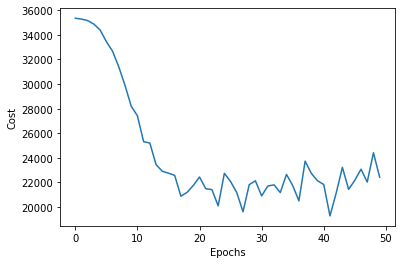

In [11]:
nn.get_loss_plot()

In [12]:
kk = locals()
n_models = 3
def nns(X_train, y_train, fig, axs, is_sigmoid=True, dropout_rate=0.8, n_layers=3):
    if is_sigmoid:
        kk['nn_0'] = NeuralNetMLP(n_layers=n_layers)
        kk['nn_1'] = NeuralNetMLP(initializer='Xavier', n_layers=n_layers)
        kk['nn_2'] = NeuralNetMLP(dropout_rate=dropout_rate, n_layers=n_layers)
    else:
        kk['nn_0'] = NeuralNetMLP(is_sigmoid=False, n_layers=n_layers)
        kk['nn_1'] = NeuralNetMLP(is_sigmoid=False, initializer='Xavier', n_layers=n_layers)
        kk['nn_2'] = NeuralNetMLP(is_sigmoid=False, dropout_rate=dropout_rate, n_layers=n_layers)
    for i in range(n_models):
        kk['nn_{}'.format(i)].fit(X_train=X_train[:idx],\
        y_train=y_train[:idx],\
        X_valid=X_train[idx:],\
        y_valid=y_train[idx:])
        
    title = ['default', 'Xavier', 'dropout']
    
    col = ['red', 'blue']
    label = ['train', 'valid']


    for i in range(n_models):
        acc = [kk['nn_{}'.format(i)].eval_['train_acc'], \
               kk['nn_{}'.format(i)].eval_['valid_acc']]
        axs[0, i].set_title('R_square_' + title[i])
        axs[0, i].set_ylim([-8, 2])
        for l in range(len(col)):
            axs[0, i].plot(acc[l], color=col[l], label=label[l])
            axs[0, i].legend(frameon=True)
        axs[1, i].set_title('loss_' + title[i])
        axs[1, i].plot(range(kk['nn_{}'.format(i)].epochs), \
                    kk['nn_{}'.format(i)].eval_['cost'])
    fig.suptitle('n_layers: {}, n_hidden: {}'.format(n_layers, nn_0.n_hidden))
    return fig

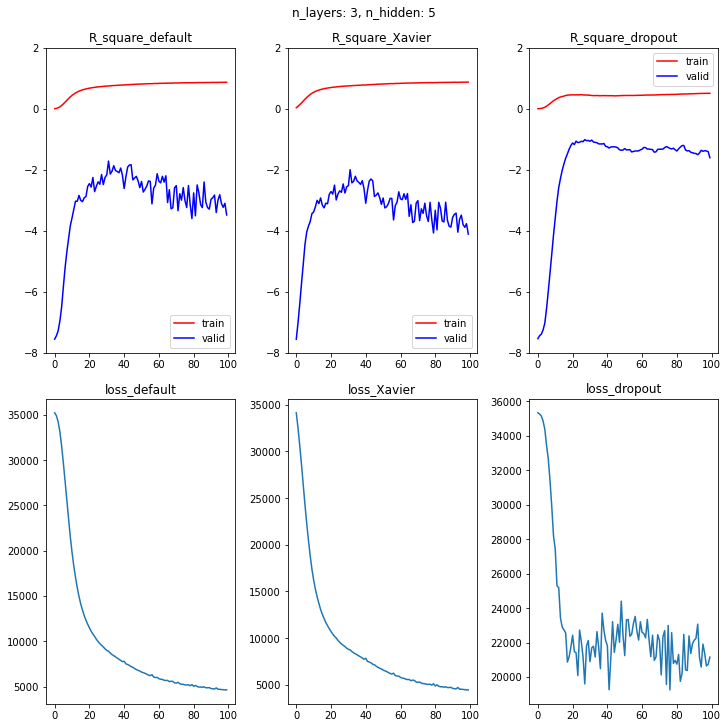

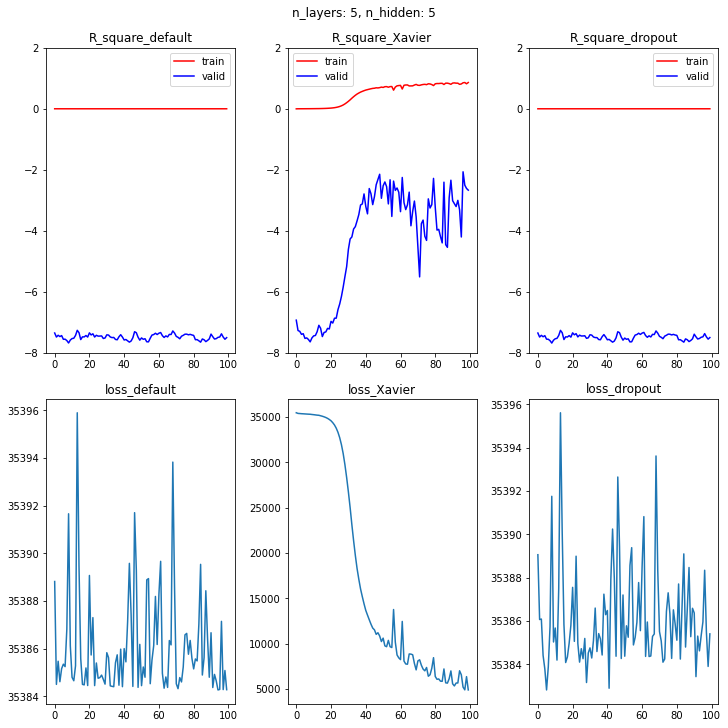

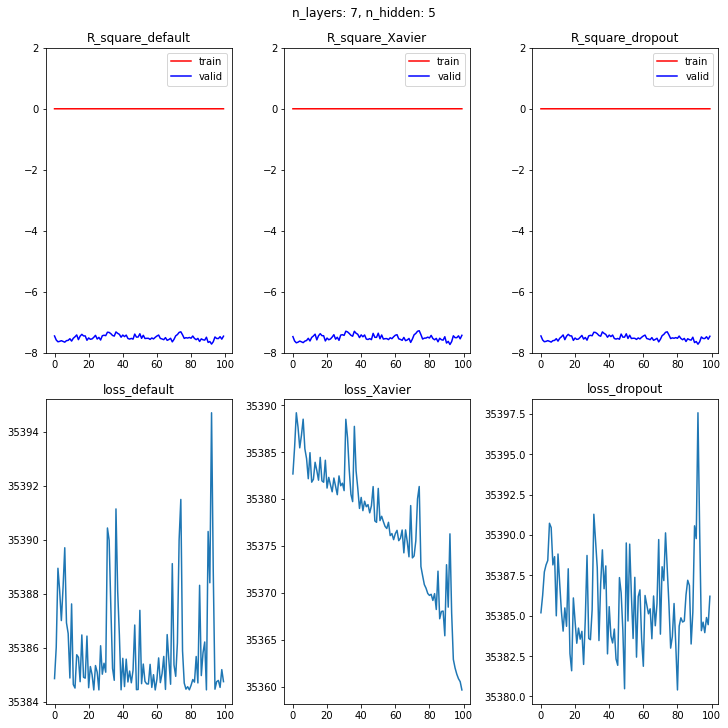

In [13]:
n_n_layers = 3
for i in range(n_n_layers):
    n_layers = 3 + i*2
    kk['fig_{}'.format(i)], kk['axs_{}'.format(i)] = \
    plt.subplots(2, n_models, constrained_layout=True, figsize = (10, 10))
    kk['fig_{}'.format(i)] = nns(X_train, y_train, kk['fig_{}'.format(i)], kk['axs_{}'.format(i)]\
                                 , is_sigmoid=True, dropout_rate=0.5, n_layers=n_layers)